## FRUIT-QUALITY

Queremos poder analizar las frutas que pueden haber en una fábrica para conocer si estas están en buen estado para la venta de estas, o si por el contrario necesitaríamos tirarla ya que esta se encuentra en mal estado y no sería recomendable su venta.

Comenzaremos mostrando la imagen de la manzana buena, que nos indicaría como sería la manzana perfecta para su venta, y al lado una manzana en mal estado para comprobar que esta no se podría llegar a vender por sus fallos.

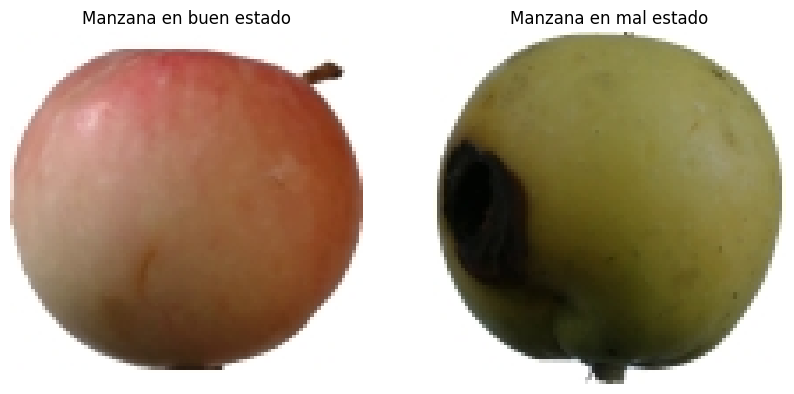

In [50]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
images_path = './images/'

# Mostramos la imagen de la manzana buena y mala
img_buena = cv2.imread(images_path + "ManzanaB.jpg")
img_mala = cv2.imread(images_path + "ManzanaM_2.jpg")
img_buena_rgb = cv2.cvtColor(img_buena, cv2.COLOR_BGR2RGB)
img_mala_rgb = cv2.cvtColor(img_mala, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Manzana en buen estado")
plt.imshow(img_buena_rgb)
plt.axis("off")

plt.subplot(1,2,2)
plt.title("Manzana en mal estado")
plt.imshow(img_mala_rgb)
plt.axis("off")
plt.show()

Una vez mostradas las imágenes, las convertimos a la escala de grises para poder verlas mejor y las suavizamos para eliminar todo tipo de errores.

Usamos un suavizado Gaussiano para el suavizado de la imagen, esta se lleva a cabo mediante una operación de convolución, donde se utiliza un kernel. En primer lugar:

    - Nos calcula un promedio ponderado de todos los valores de los píxeles vecinos.
    - El kernel es una pequeña matriz de números donde el píxel central recibe el peso más alto, y los pesos de los vecinos van disminuyendo gradualmente a medida que se alejan del centro.

Al aplicar el ponderado a cada píxel, los cambios bruscos de intensidad se suavizan, ya que los valores de los píxeles de los extremos se atenuan por el promedio de sus vecinos cercanos.

Esto nos ayuda a mejorar la detección de los bordes y las regiones oscuras reales.

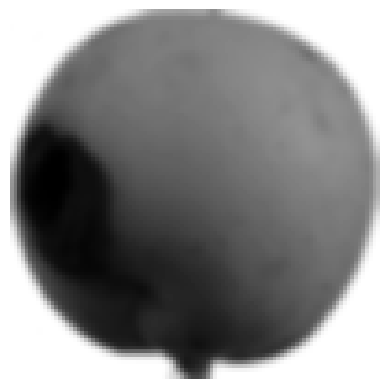

In [51]:
gray = cv2.cvtColor(img_mala, cv2.COLOR_BGR2GRAY)
gray_blur = cv2.GaussianBlur(gray, (5, 5), 0)

plt.imshow(gray_blur, cmap='gray')
plt.axis("off")
plt.show()

Una vez hemos suavizado la imagen, pasamos a calcular las derivadas usando Sobel.
Aplicamos la derivada tanto para el eje X como para el eje Y, estas nos indican dónde cambia la intensidad de una manera muy brusca.

Si combinamos ambas magnitudes, podremos obtener la zona de cambios fuertes de textura, donde podremos encontrar la zona "mala" de la fruta.

Nos sirve mucho aplicar la derivada ya que los agujeros o las zonas podridas en frutas normalmente suelen tener los bordes marcados por el contraste, por lo que este método nos enseñará las zonas con agujeros que existen en la fruta.

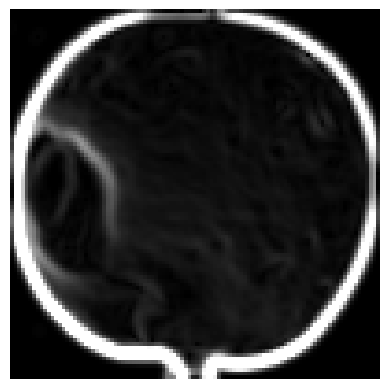

In [52]:
sobelx = cv2.Sobel(gray_blur, cv2.CV_64F, 1, 0, ksize=3)
sobely = cv2.Sobel(gray_blur, cv2.CV_64F, 0, 1, ksize=3)
gradiente = cv2.magnitude(sobelx, sobely)
gradiente = cv2.convertScaleAbs(gradiente)

plt.imshow(gradiente, cmap='gray')
plt.axis("off")
plt.show()

En la imagen anterior, podemos ver como se nos marca las zonas donde ha habido un cambio de intensidades más fuerte en la manzana.

Se marca la zona donde hay un agujero en la manzana por estar en mal estado, una vez que se nos marca donde está la zona esta, podemos crear una LUT.

La LUT (Look-Up Table), nos sirve para mapear un conjunto de valores de entrada al conjunto de valores de salida predefinidos.
Nos genera un mapa de puntuación de defectos, nuestro objetivo es tener una imagen donde el valor de cada uno de los píxeles representa la probabilidad o la intensidad de un defecto en esa posición.

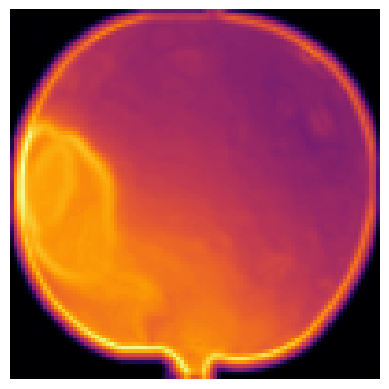

In [53]:
gray_norm = cv2.normalize(gray_blur, None, 0, 255, cv2.NORM_MINMAX)
grad_norm = cv2.normalize(gradiente, None, 0, 255, cv2.NORM_MINMAX)

defect_score = cv2.addWeighted(255 - gray_norm, 0.7, grad_norm, 0.3, 0)

plt.imshow(defect_score, cmap='inferno')
plt.axis("off")
plt.show()

En la imagen, aparece la zona donde hay una deformación con un color más claro que en el resto de la imagen. Esto se debe a que el defecto hace que el término (255 - gray_norm) sea bastante alto, lo que hará que tenga una puntuación elevada.

Una vez ya tenemos analizada toda la fruta, deberemos crear una máscara en esta zona para conocer la parte afectada. Nos marcará lo que queremos obtener, es decir la parte donde hay una deformación, en color blanco, mientras que el resto de la imagen nos la pondrá en negro para así poder ver bien que es lo que buscamos.

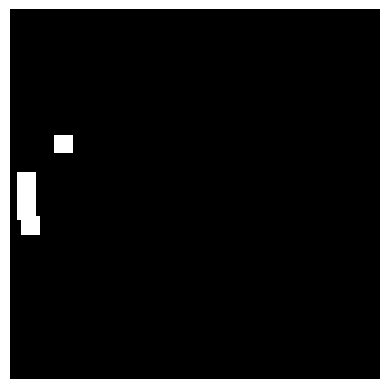

In [54]:
_, defect_mask = cv2.threshold(defect_score, 180, 255, cv2.THRESH_BINARY)
defect_mask = cv2.morphologyEx(defect_mask, cv2.MORPH_OPEN, np.ones((5,5), np.uint8))

plt.imshow(defect_mask, cmap='gray')
plt.axis("off")
plt.show()

Primero tomamos la imagen una vez aplicada la derivada y la LUT, y buscamos donde la puntuación de cada píxel sea mayor a 180, lo que nos indicará que este tiene un defecto y por lo tanto se volverá blanco.

Después eliminamos todo el ruido que pueda haber en la imagen quitando los pequeños puntos blancos aislados que puede haber que no son defectos reales, sino errores de detección.

Por último se rellenan los pequeños huecos que hay en las zonas de defecto para que esta salga con regiones continuas y bien definidas para poder analizar bien las zonas de defecto.


Ya tenemos todo lo necesario para analizar las partes defectuosas de las frutas, por lo que el trabajo estaría completado, vamos a mejorar un poco nuestro resultado final para que también nos indique si la fruta está en buen estado o no. Para ello diremos que si la fruta tiene una sección en la que hay un agujero que tenga un tamaño considerable, se dirá que la fruta está en mal estado y por lo tanto se dispondrá a su eliminación. Si por el contrario, la fruta no dispone de ninguna malformación, en la imagen no se mostrará nada y por lo tanto estará disponible para su venta o consumición.

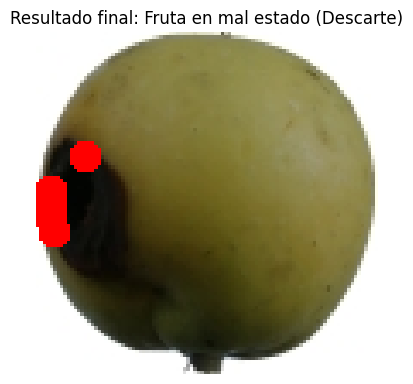

In [55]:
# Inicializa las variables para el análisis
total_pixels = gray.shape[0] * gray.shape[1]
defect_pixels_total = cv2.countNonZero(defect_mask)
porcentaje_defecto = (defect_pixels_total / total_pixels) * 100

UMBRAL_AREA_GRAVE = 15

estado = "Fruta en buen estado"
hay_defecto_grave = False

contornos, _ = cv2.findContours(defect_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

hay_defecto_grave = any(cv2.contourArea(contorno) > UMBRAL_AREA_GRAVE for contorno in contornos)

resultado = img_mala_rgb.copy()

if hay_defecto_grave:
    estado = "Fruta en mal estado (Descarte)"
    cv2.drawContours(resultado, contornos, -1, (255, 0, 0), thickness=3)
else:
    estado = "Fruta en buen estado (Venta o Consumición)"

plt.figure(figsize=(15,5))
plt.subplot(1,3,3)
plt.title(f"Resultado final: {estado}")
plt.imshow(resultado)
plt.axis("off")

plt.show()

Para determinar el número de píxeles necesarios para que la manzana se considere en mal estado, hemos colocado un umbral que llamamos "UMBRAL_AREA_GRAVE", este umbral se estima en 15, debido a que las imágenes que uso son de 100x100 píxeles, y por lo tanto con que haya 15 píxeles en mal estado podríamos considerarla en mal estado y no sería posible su venta al público.


Una vez que tenemos ya todo hecho, colocamos todas las imágenes importantes para resumir nuestro resultado.

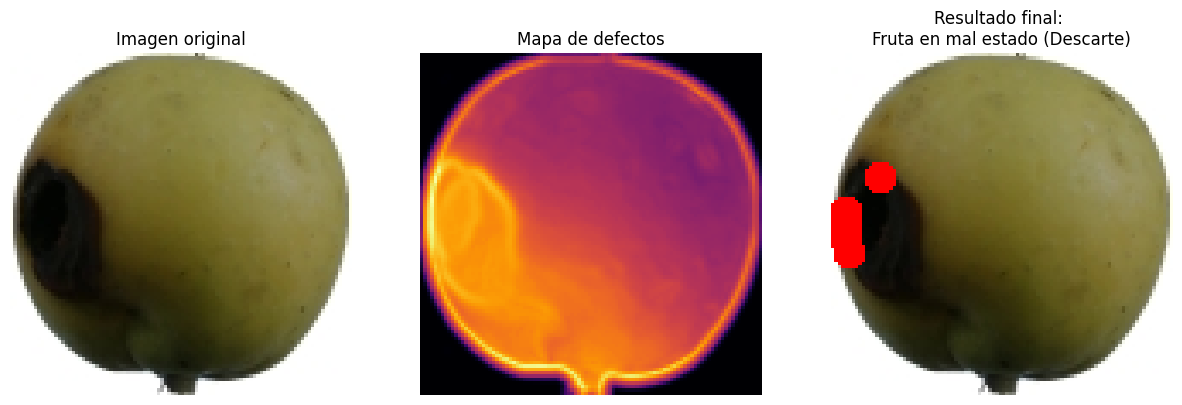

In [56]:
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.title("Imagen original")
plt.imshow(img_mala_rgb)
plt.axis("off")

plt.subplot(1,3,2)
plt.title("Mapa de defectos")
plt.imshow(defect_score, cmap="inferno")
plt.axis("off")

plt.subplot(1,3,3)
plt.title(f"Resultado final: \n{estado}")
plt.imshow(resultado)
plt.axis("off")

plt.show()
